In [104]:
%matplotlib inline

import os
import sys

sys.path.append('../global_search/')
sys.path.append('../../txf_design_space/embeddings')

from utils import embedding_util

from utils import graph_util 

import yaml
import collections
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from skopt.sampler import Sobol
from sklearn.manifold import TSNE as tsne

In [3]:
# Load design space
design_space = yaml.safe_load(open('../global_search/design_space/design_space.yaml'))

In [4]:
# Check basic conversion to 
bert_mini_model_dict = {"l": 4, "o": 
                        [["sa_sdp_64", "sa_sdp_64", "sa_sdp_64", "sa_sdp_64"], 
                         ["sa_sdp_64", "sa_sdp_64", "sa_sdp_64", "sa_sdp_64"], 
                         ["sa_sdp_64", "sa_sdp_64", "sa_sdp_64", "sa_sdp_64"], 
                         ["sa_sdp_64", "sa_sdp_64", "sa_sdp_64", "sa_sdp_64"]], 
                        "h": [256, 256, 256, 256], "f": [[1024], [1024], [1024], [1024]]}

bert_mini_embedding = embedding_util.model_dict_to_embedding(bert_mini_model_dict, design_space)

print(f'BERT-Mini\'s embedding: {bert_mini_embedding}')

model_dict = embedding_util.embedding_to_model_dict(bert_mini_embedding, design_space)

print(f'BERT-Mini\'s model dictionary: {model_dict}')

BERT-Mini's embedding: [1, 1, 2, 28, 1, 2, 28, 1, 2, 28, 1, 2, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
BERT-Mini's model dictionary: {'l': 4, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64']], 'h': [256, 256, 256, 256], 'f': [[1024], [1024], [1024], [1024]]}


In [5]:
# Check if BERT-Mini's embedding is valid
embedding_util.is_valid_embedding(bert_mini_embedding, design_space)

True

In [12]:
# Test Sobol samples
narrow_sampler = Sobol()
wide_sampler = Sobol()

narrow_embedding_bounds = embedding_util.get_embedding_bounds(design_space, type='narrow')
wide_embedding_bounds = embedding_util.get_embedding_bounds(design_space, type='wide')

narrow_sampled_embeddings = narrow_sampler.generate(narrow_embedding_bounds, 128)
wide_sampled_embeddings = wide_sampler.generate(wide_embedding_bounds, 128)

narrow_valid_embeddings = \
    [embedding_util.get_nearest_valid_embedding(embedding, design_space) for embedding in narrow_sampled_embeddings]
wide_valid_embeddings = \
    [embedding_util.get_nearest_valid_embedding(embedding, design_space) for embedding in wide_sampled_embeddings]

narrow_model_dicts = \
    [embedding_util.embedding_to_model_dict(embedding, design_space) for embedding in narrow_valid_embeddings]
wide_model_dicts = \
    [embedding_util.embedding_to_model_dict(embedding, design_space) for embedding in wide_valid_embeddings]

narrow_model_types = [embedding_util.get_model_type(model_dict, design_space) for model_dict in narrow_model_dicts]
wide_model_types = [embedding_util.get_model_type(model_dict, design_space) for model_dict in wide_model_dicts]

print(f'Narrow model types: {collections.Counter(narrow_model_types)}')
print(f'Wide model types: {collections.Counter(wide_model_types)}')

all_model_dicts = narrow_model_dicts + wide_model_dicts
all_hashes = []

for model_dict in all_model_dicts:
    model_graph = graph_util.model_dict_to_graph(model_dict)
    model_hash = graph_util.hash_graph(*model_graph, model_dict=model_dict)
    all_hashes.append(model_hash)
    
assert len(set(all_hashes)) == len(all_model_dicts) 

Narrow model types: Counter({'deep_narrow': 64, 'shallow_narrow': 64})
Wide model types: Counter({'deep_wide': 64, 'shallow_wide': 64})


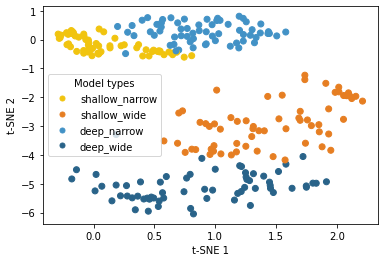

In [110]:
# Plot embeddings
all_embeddings = narrow_valid_embeddings + wide_valid_embeddings

model_type_to_color = {'shallow_narrow': '#F1C40F', 
                       'shallow_wide': '#E67E22', 
                       'deep_narrow': '#4292C6',
                      'deep_wide': '#296389'}

colors = []
for embedding in all_embeddings:
    model_dict = embedding_util.embedding_to_model_dict(embedding, design_space)
    model_type = embedding_util.get_model_type(model_dict, design_space)
    colors.append(model_type_to_color[model_type])

embeddings_2d = tsne(n_components=2, 
                     learning_rate='auto', 
                     perplexity=122,
                     early_exaggeration=1,
                     init='random', 
                     random_state=3).fit_transform(np.array(all_embeddings))

scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

custom = [Line2D([], [], marker='.', markersize=10, color=color, linestyle='None') 
          for color in model_type_to_color.values()]
plt.legend(custom, model_type_to_color.keys(), title='Model types')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()